In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True

import dask
print(f'dask: {dask.__version__}')
import dask.array
dask.config.set({'array.chunk-size': '512MiB'})

from psutil import virtual_memory

mem = virtual_memory()
print(f'Physical memory: {mem.total/1024/1024/1024:.0f} Gb')  # total physical memory available

import logging
logging.basicConfig(filename='example.log', level=logging.DEBUG)

import toolbox_scs as tb
print(tb.__file__)
import toolbox_scs.routines.boz as boz

import os

dask: 2023.3.2
Physical memory: 754 Gb
/home/lleguy/notebooks/ToolBox-git/src/toolbox_scs/__init__.py


In [2]:
import sys
print(sys.executable)

/gpfs/exfel/u/scratch/SCS/202301/p003423/envs/toolbox_p003423-gpu/bin/python


In [3]:
%load_ext autoreload

%autoreload 2

# Create parameters object

In [4]:
proposal = 2937
darkrun = 615
run = 614
module = 15
gain = 3
drop_intra_darks = True
sat_level = 490
rois_th = 0.08
ff_prod_th = 350
ff_ratio_th = 0.75

In [5]:
# Parameters
proposal = 2937
darkrun = 615
run = 614
module = 15
gain = 3.0
rois_th = 0.18
sat_level = 500


In [6]:
params = boz.parameters(proposal=proposal, darkrun=darkrun, run=run, module=module, gain=gain, drop_intra_darks=drop_intra_darks)

In [7]:
from extra_data.read_machinery import find_proposal

root = find_proposal(f'p{proposal:06d}')
path = root + f'/usr/processed_runs/r{params.run:04d}/'
print(path)
os.makedirs(path, exist_ok=True)
prefix = f'p{proposal}-r{run}-d{darkrun}-BOZ-Ia'

/gpfs/exfel/exp/SCS/202122/p002937/usr/processed_runs/r0614/


In [8]:
print(params)

proposal:2937 darkrun:615 run:614 module:15 gain:3.0 ph/bin
drop intra darks:True
mask:None
rois threshold: None
rois: None
flat-field p: None prod:(5.0, inf) ratio:(-inf, 1.2)
plane guess fit: None
use hexagons: False
enforce mirror symmetry: True
ff alpha: None, max. iter.: None
Fnl: None


# Load data persistently

In [9]:
params.dask_load_persistently()

/gpfs/exfel/u/scratch/SCS/202301/p003423/envs/toolbox_p003423-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  exec(code_obj, self.user_global_ns, self.user_ns)
/gpfs/exfel/u/scratch/SCS/202301/p003423/envs/toolbox_p003423-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.sli

## Slice the data by trainId if the number of pulses is large

In [10]:
params.arr_dark

dask.array<rechunk-merge, shape=(712, 20, 128, 512), dtype=uint16, chunksize=(204, 20, 128, 512), chunktype=numpy.ndarray>

In [11]:
# keep only 1Gb of data
N = int(1*1024**3/(params.arr_dark.shape[1]*128*512*2))
SLICE = slice(0, N)
params.arr_dark = params.arr_dark[SLICE]
params.tid_dark = params.tid_dark[SLICE]

In [12]:
params.arr

dask.array<rechunk-merge, shape=(2124, 20, 128, 512), dtype=uint16, chunksize=(204, 20, 128, 512), chunktype=numpy.ndarray>

In [13]:
# keep only 4Gb of data
N = int(4*1024**3/(params.arr.shape[1]*128*512*2))
SLICE = slice(0, N)
params.arr = params.arr[SLICE]
params.tid = params.tid[SLICE]

In [14]:
params.arr

dask.array<getitem, shape=(1638, 20, 128, 512), dtype=uint16, chunksize=(204, 20, 128, 512), chunktype=numpy.ndarray>

# Use GPU

In [15]:
dask.config.set(scheduler="single-threaded")
params.use_gpu()

# Dark run inspection

The aim is to check dark level and extract bad pixel map.

In [16]:
dark = boz.average_module(params.arr_dark).compute()

In [17]:
pedestal = boz.ensure_on_host(np.mean(dark))
pedestal

array(40.97503102)

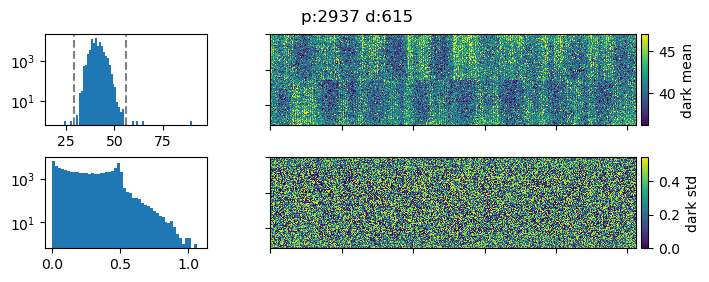

In [18]:
mean_th = (pedestal-12, pedestal+15)
f = boz.inspect_dark(boz.ensure_on_host(params.arr_dark),
                     mean_th=mean_th)
f.suptitle(f'p:{params.proposal} d:{params.darkrun}')
fname = path + prefix + '-inspect_dark.png'
f.savefig(fname, dpi=300) 

In [19]:
params.mean_th = mean_th
params.set_mask(boz.bad_pixel_map(params))

# bad pixel: 12


In [20]:
print(params)

proposal:2937 darkrun:615 run:614 module:15 gain:3.0 ph/bin
drop intra darks:True
mean threshold:(28.975031015633952, 55.97503101563395) std threshold:(None, None)
mask:(#12) [[15, 437], [36, 477], [43, 506], [59, 215], [61, 215], [63, 28], [71, 451], [76, 302], [80, 223], [80, 224], [108, 185], [125, 296]]
rois threshold: None
rois: None
flat-field p: None prod:(5.0, inf) ratio:(-inf, 1.2)
plane guess fit: None
use hexagons: False
enforce mirror symmetry: True
ff alpha: None, max. iter.: None
Fnl: None


# Veto pattern check

Check potential veto pattern issue

In [21]:
data = boz.average_module(params.arr, dark=dark).compute()
pp = boz.ensure_on_host(data.mean(axis=(1,2))) # pulseId resolved mean
dataM = boz.ensure_on_host(data.mean(axis=0)) # mean over pulseId

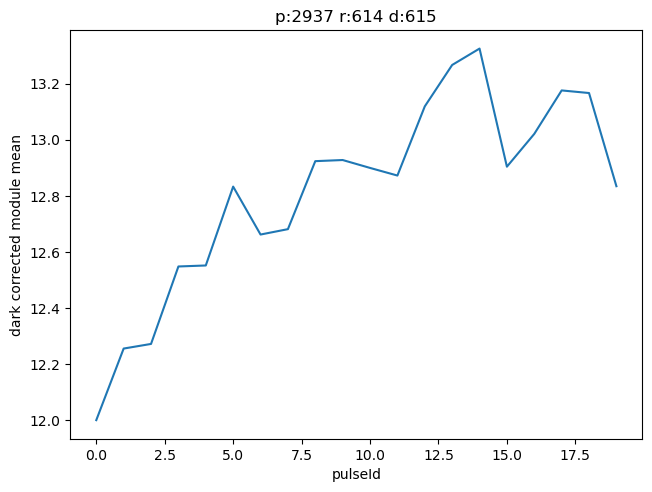

In [22]:
plt.figure()
plt.plot(pp)
plt.xlabel('pulseId')
plt.ylabel('dark corrected module mean')
plt.title(f'p:{params.proposal} r:{params.run} d:{params.darkrun}')
plt.savefig(path+prefix+'-veto_inspect.png', dpi=300)

In [23]:
# Thresholding out bad veto pulse
"""
threshold = 5
if False:
    params.arr = params.arr[:, pp > threshold, :, :]
    params.arr_dark = params.arr_dark[:, pp > threshold, :, :]
    dark = boz.average_module(params.arr_dark).compute()
    data = boz.average_module(params.arr, dark=dark).compute()
    dataM = data.mean(axis=0) # mean over pulseId
"""

'\nthreshold = 5\nif False:\n    params.arr = params.arr[:, pp > threshold, :, :]\n    params.arr_dark = params.arr_dark[:, pp > threshold, :, :]\n    dark = boz.average_module(params.arr_dark).compute()\n    data = boz.average_module(params.arr, dark=dark).compute()\n    dataM = data.mean(axis=0) # mean over pulseId\n'

# Histogram

/home/lleguy/notebooks/ToolBox-git/src/toolbox_scs/routines/boz.py:598: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  h = ensure_on_host(histogram_module(arr, mask=mask))


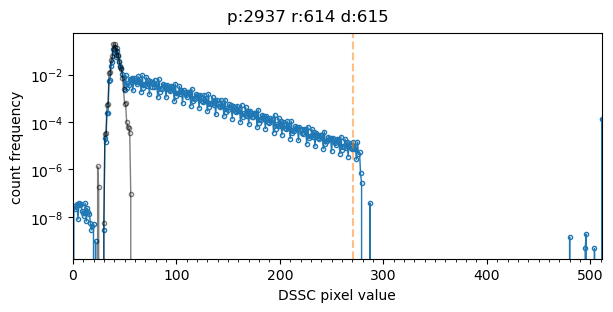

In [24]:
h, f = boz.inspect_histogram(boz.ensure_on_host(params.arr),
                             boz.ensure_on_host(params.arr_dark),
                             mask=boz.ensure_on_host(params.get_mask())
                             #, extra_lines=True
                         )
f.suptitle(f'p:{params.proposal} r:{params.run} d:{params.darkrun}')
f.savefig(path+prefix+'-histogram.png', dpi=300)

# ROIs extraction

In [25]:
params.rois_th = rois_th
params.rois = boz.find_rois_from_params(params)

In [26]:
print(params)

proposal:2937 darkrun:615 run:614 module:15 gain:3.0 ph/bin
drop intra darks:True
mean threshold:(28.975031015633952, 55.97503101563395) std threshold:(None, None)
mask:(#12) [[15, 437], [36, 477], [43, 506], [59, 215], [61, 215], [63, 28], [71, 451], [76, 302], [80, 223], [80, 224], [108, 185], [125, 296]]
rois threshold: 0.18
rois: {'n': {'xl': 12, 'xh': 89, 'yl': 22, 'yh': 105}, '0': {'xl': 89, 'xh': 167, 'yl': 22, 'yh': 105}, 'p': {'xl': 167, 'xh': 244, 'yl': 22, 'yh': 105}, 'sat': {'xl': 12, 'xh': 244, 'yl': 22, 'yh': 105}}
flat-field p: None prod:(5.0, inf) ratio:(-inf, 1.2)
plane guess fit: None
use hexagons: False
enforce mirror symmetry: True
ff alpha: None, max. iter.: None
Fnl: None


/home/lleguy/notebooks/ToolBox-git/src/toolbox_scs/routines/boz.py:767: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  main_ax.pcolormesh(Xs, Ys, np.flipud(data_mean[:, :256]),


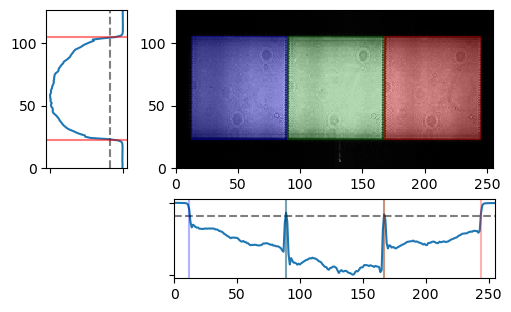

In [27]:
f = boz.inspect_rois(dataM, params.rois, params.rois_th)
f.savefig(path+prefix+f'-rois.png', dpi=300)

# Flat field extraction

The first step is to compute a good average image, this mean remove saturated shots and ignoring bad pixels

In [28]:
params.sat_level = sat_level
res = boz.average_module(params.arr, dark=dark,
                         ret='mean', mask=params.get_mask(), sat_roi=params.rois['sat'],
                         sat_level=params.sat_level)
avg = res.mean(axis=0).compute()

The second step is from that good average image to fit the plane field on n/0 and p/0 rois. We have to make sure that the rois have same width.

In [29]:
# default values
params.flat_field_prod_th = (5.0, np.PINF)
params.flat_field_ratio_th = (np.NINF, 1.2)
params.use_hex = False
params.force_mirror = False
params.ff_alpha = 0.1
params.ff_max_iter = 25

print(params)

proposal:2937 darkrun:615 run:614 module:15 gain:3.0 ph/bin
drop intra darks:True
mean threshold:(28.975031015633952, 55.97503101563395) std threshold:(None, None)
mask:(#12) [[15, 437], [36, 477], [43, 506], [59, 215], [61, 215], [63, 28], [71, 451], [76, 302], [80, 223], [80, 224], [108, 185], [125, 296]]
rois threshold: 0.18
rois: {'n': {'xl': 12, 'xh': 89, 'yl': 22, 'yh': 105}, '0': {'xl': 89, 'xh': 167, 'yl': 22, 'yh': 105}, 'p': {'xl': 167, 'xh': 244, 'yl': 22, 'yh': 105}, 'sat': {'xl': 12, 'xh': 244, 'yl': 22, 'yh': 105}}
flat-field p: None prod:(5.0, inf) ratio:(-inf, 1.2)
plane guess fit: None
use hexagons: False
enforce mirror symmetry: False
ff alpha: 0.1, max. iter.: 25
Fnl: None


## Refining flat field

In [30]:
res, cb = boz.ff_refine_fit(params)

0: 0:00:00.000001 (18.4836060294627, 95.86388810686377, 792.2864268034733), [-0.2, -0.1, 1, -0.54, 0.2, -0.1, 1, -0.54]
1: 0:00:14.281071 (1.704098033186518, 74.25427490721434, 727.2058667734647), [-0.2058043  -0.0792378   1.00268546 -0.53672204  0.20203086 -0.09360214
  0.97615395 -0.58459197]
2: 0:00:18.655748 (11.890682695560002, 61.75454580368649, 510.5293137768249), [-0.22922627 -0.00316114  0.97621938 -0.58932566  0.21332385 -0.07818025
  0.96348728 -0.60881437]
3: 0:00:23.169202 (1.9664154222668786, 54.483411566268536, 527.1363768622834), [-0.26789167  0.08104171  0.991437   -0.5666215   0.23390899 -0.02913895
  0.97200164 -0.59716311]
4: 0:00:30.855880 (2.788852315822956, 51.780828173217316, 492.7086108897666), [-0.28686793  0.08023693  0.99309416 -0.5720163   0.24892017  0.0086582
  0.9721102  -0.59781099]
5: 0:00:35.233928 (2.8306980133010997, 46.731008152166524, 441.83379940195533), [-0.33479122  0.073223    1.00089164 -0.57662417  0.2996213   0.01636881
  0.96678814 -0.5967

In [31]:
params.set_flat_field(res.x)

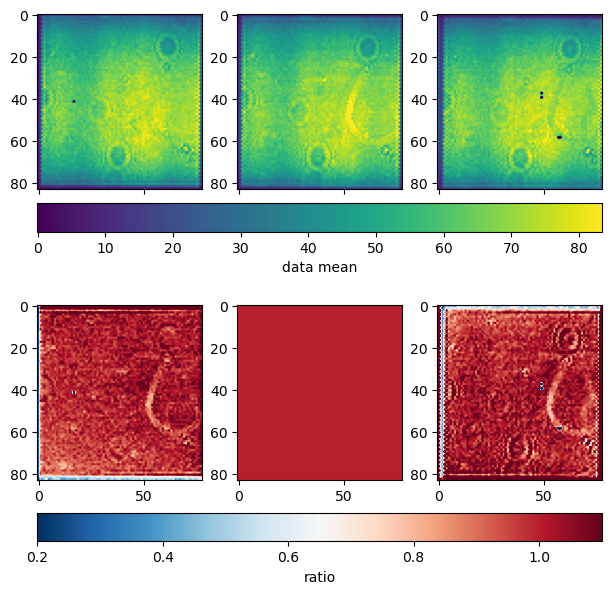

In [32]:
ff = boz.compute_flat_field_correction(params.rois, params)
f = boz.inspect_plane_fitting(boz.ensure_on_host(avg)/ff, params.rois)
f.savefig(path+prefix+'-inspect-withflatfield-refined.png', dpi=300)

# Non-linearities correction extraction

To speed up online analysis, we save the corrections with a dummy non-linearity correction. The saved file can be used for online analysis as soon as it appears.

In [33]:
params.set_Fnl(np.arange(2**9))
params.save(path=path)

/gpfs/exfel/exp/SCS/202122/p002937/usr/processed_runs/r0614/parameters_p2937_d615_r614.json


In [34]:
N = 80
domain = boz.nl_domain(N, 40, 511)
params.nl_alpha = 0.5
params.nl_max_iter = 25

## minimizing

In [35]:
res, fit_res = boz.nl_fit(params, domain)

0: 0:00:00.000001 (3086.0699271427047, 1543.0349635713524, 0.0), [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
1: 0:00:58.777819 (1486.0545571870425, 746.0852336389034, 6.115910090764297), [-1.57636853e-01 -4.99656139e-01 -4.12595060e-02  4.91009113e-01
  4.91730605e-01  3.52349007e-01  9.33380898e-02 -4.54187036e-02
 -1.40888962e-01 -1.91877987e-01 -1.62450269e-01 -1.31042085e-01
 -1.10913045e-01 -8.06552446e-02 -4.61741230e-02 -3.09095183e-02
 -1.50260207e-02  8.84763575e-04  1.29982137e-02  1.83006270e-02
  2.49125057e-02  2.18491230e-02  2.26397447e-02  2.27667555e-02
  2.00809841e-02  1.76044770e-02  1.32664669e-02  9.73182337e-03
  8.40726981e-03  4.19531553e-03  3.66141318e-03  2.65210996e-03
  1.38896229e-03  9.11011464e-04  4.56409049e-04  2.92753558e-04
  1.26513645e-04  7.69714922e-05  3.40700753e-05  1.52505553e-05
  1.91493415e-06  0.00000000e+00  0.0000000

7: 0:04:27.900157 (1030.0318523499377, 526.5092541875989, 22.98665602526022), [-2.08136666e-01 -6.37634014e-02  2.15604662e-01  6.08830771e-01
  9.33237150e-01  8.80906758e-01  4.71595009e-01  2.23984119e-01
  5.72674353e-02 -3.23997482e-02 -2.11437174e-02 -2.17730850e-02
 -4.92873752e-02 -1.60892819e-01 -2.74067729e-01 -4.17975420e-01
 -5.70015441e-01 -5.03147458e-01 -4.85727527e-01 -3.04495795e-01
 -2.00485292e-01 -5.46222323e-02  3.08481454e-02  1.18823306e-01
  1.82361771e-01  2.25275464e-01  2.15036656e-01  1.84640133e-01
  1.80315938e-01  9.79144032e-02  9.05513139e-02  6.88610553e-02
  3.75310753e-02  2.52357195e-02  1.29109109e-02  8.50192328e-03
  3.69289737e-03  2.33335980e-03  1.04205834e-03  4.69314699e-04
  5.52322272e-05  0.00000000e+00  0.00000000e+00 -1.16780373e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000

13: 0:07:57.509786 (451.5572067764707, 246.68270049959162, 41.80819422271255), [-2.71639785e-01 -2.74471859e-01  4.63203077e-02  2.41993437e-02
  6.31128460e-01 -1.81741861e-01  3.96920047e-01 -3.72745532e-01
 -5.87532755e-01 -1.86668367e-01 -3.59265687e-01 -6.61061477e-01
 -7.99887781e-01 -5.71673879e-01 -4.58427729e-01 -4.81624390e-01
 -8.01880564e-01 -7.70770710e-01 -9.51238900e-01 -7.77301035e-01
 -7.22922329e-01 -3.47924947e-01 -3.52501047e-01 -1.77723573e-01
 -9.40529337e-04  1.60161647e-01  2.37431906e-01  2.51620159e-01
  2.70602856e-01  8.51544868e-02  1.47896830e-01  1.14716738e-01
  6.18684230e-02  4.25683609e-02  2.26373673e-02  1.50800132e-02
  3.23809814e-03  4.37899547e-03  2.40124671e-03  1.14088281e-03
  2.21144245e-04  0.00000000e+00  0.00000000e+00  1.17607666e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.0000000

19: 0:13:22.988183 (442.92547055591086, 229.83458975919572, 16.743708962480607), [-8.01228164e-02  7.85617819e-03  3.68280852e-01  4.66017877e-01
  8.17691400e-01  5.93033826e-01  3.85497394e-01  2.43708751e-01
  1.48697482e-01  1.09754977e-01  2.65641478e-02 -1.25959083e-01
 -1.38534190e-01 -1.22283099e-01 -1.66710459e-01 -2.26794493e-01
 -3.43025451e-01 -4.02824467e-01 -4.54319174e-01 -3.62904427e-01
 -3.57331794e-01 -2.65442484e-01 -1.66513699e-01 -8.16264783e-02
  3.64795303e-02  1.43366603e-01  1.99734919e-01  2.05948742e-01
  2.31404194e-01  1.57457509e-01  1.34962077e-01  1.07869107e-01
  6.15381387e-02  4.21761514e-02  2.18115537e-02  1.46802362e-02
  7.37514163e-03  4.15288590e-03  1.77627007e-03  7.85665090e-04
  7.13405621e-05  0.00000000e+00  0.00000000e+00 -7.31245956e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000

25: 0:17:50.966772 (442.92620525360365, 229.83457125323253, 16.742937252861374), [-8.00453334e-02  7.62612083e-03  3.68112793e-01  4.65716488e-01
  8.17287237e-01  5.92789810e-01  3.85099098e-01  2.43318538e-01
  1.48217035e-01  1.09508744e-01  2.64204350e-02 -1.26275695e-01
 -1.39399786e-01 -1.22860948e-01 -1.66420706e-01 -2.26657858e-01
 -3.43191302e-01 -4.03181635e-01 -4.54859594e-01 -3.63298806e-01
 -3.57576383e-01 -2.65715514e-01 -1.66431840e-01 -8.14228426e-02
  3.67432700e-02  1.43658157e-01  1.99958967e-01  2.06103849e-01
  2.31494991e-01  1.57034560e-01  1.34961857e-01  1.07848008e-01
  6.15195621e-02  4.21554264e-02  2.18073533e-02  1.46723419e-02
  7.35637424e-03  4.15214780e-03  1.78038360e-03  7.85856408e-04
  7.76728798e-05  0.00000000e+00  0.00000000e+00 -7.22107260e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000

In [36]:
params.set_Fnl(boz.nl_lut(domain, res.x))

In [37]:
print(params)

proposal:2937 darkrun:615 run:614 module:15 gain:3.0 ph/bin
drop intra darks:True
mean threshold:(28.975031015633952, 55.97503101563395) std threshold:(None, None)
mask:(#12) [[15, 437], [36, 477], [43, 506], [59, 215], [61, 215], [63, 28], [71, 451], [76, 302], [80, 223], [80, 224], [108, 185], [125, 296]]
rois threshold: 0.18
rois: {'n': {'xl': 12, 'xh': 89, 'yl': 22, 'yh': 105}, '0': {'xl': 89, 'xh': 167, 'yl': 22, 'yh': 105}, 'p': {'xl': 167, 'xh': 244, 'yl': 22, 'yh': 105}, 'sat': {'xl': 12, 'xh': 244, 'yl': 22, 'yh': 105}}
flat-field p: [-0.6223040701072852, 0.000724733782145572, 1.500176720279694, -0.8340295260244752, 0.4050030612762583, 0.003192720612202234, 0.9295524383664061, -0.5658387778696685] prod:(5.0, inf) ratio:(-inf, 1.2)
plane guess fit: [-0.2, -0.1, 1, -0.54, 0.2, -0.1, 1, -0.54]
use hexagons: False
enforce mirror symmetry: False
ff alpha: 0.1, max. iter.: 25
dFnl: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.0

mu: 0.5548827255333549, s: 0.005084289575244334, snr: 109.13672742699538
weighted mu: 0.5548458130246263, s: 0.0044434740849424535, snr: 124.86757037805747
diff mu: 0.5548827255333549, s: 0.004872386726144649, snr: 113.8831453086267
mu: 0.5976615112755194, s: 0.005382491809662051, snr: 111.03807166091065
weighted mu: 0.597788040850602, s: 0.0047850701948281725, snr: 124.92774745430208
diff mu: 0.5976615112755194, s: 0.005185181280175686, snr: 115.26337826616337
mu: 0.9285018768837483, s: 0.012200618602811707, snr: 76.10285241354643
weighted mu: 0.9281647927167087, s: 0.011232131843254469, snr: 82.63478435521786
diff mu: 0.9285018768837483, s: 0.011195132904929328, snr: 82.93799499914108
mu: 0.989131458619956, s: 0.0070755493535068804, snr: 139.79571185235378
weighted mu: 0.9884902174393602, s: 0.0054195731639837316, snr: 182.39263269079237
diff mu: 0.989131458619956, s: 0.007101403322843433, snr: 139.2867597645339
mu: 0.9920652557682886, s: 0.0066457310959286905, snr: 149.2785731845286

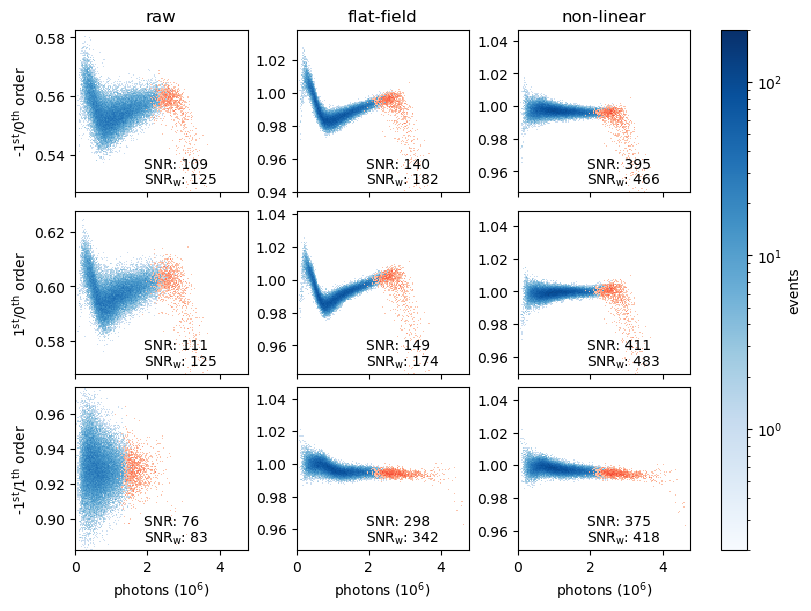

In [38]:
f = boz.inspect_correction(params, gain=params.gain)

In [39]:
f.savefig(path+prefix+'-inspect-correction.png', dpi=300)

### plotting the fitted correction

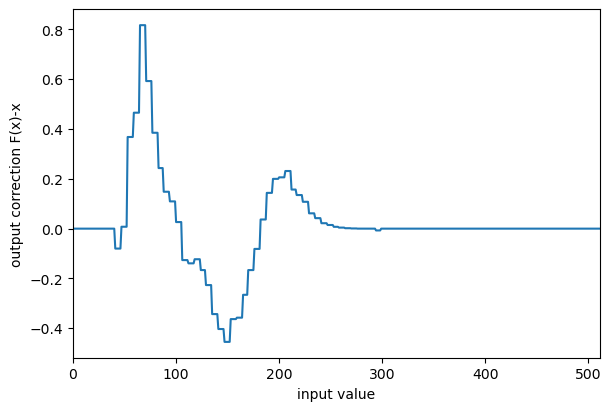

In [40]:
f = boz.inspect_Fnl(boz.ensure_on_host(params.get_Fnl()))

In [41]:
f.savefig(path+prefix+'-inspect-Fnl.png', dpi=300)

### plotting the fit progresion

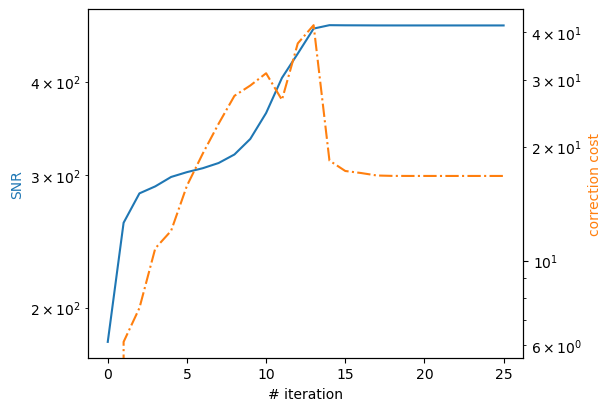

In [42]:
f = boz.inspect_nl_fit(fit_res)

In [43]:
f.savefig(path+prefix+'-inspect-nl-fit.png', dpi=300)

# Save the analysis parameters

In [44]:
params.save(path=path)

/gpfs/exfel/exp/SCS/202122/p002937/usr/processed_runs/r0614/parameters_p2937_d615_r614.json
